B nodes  : 1307
B edges  : 2417
⟶ members: 121
⟶ tickers: 1186
Filtered B2 edges: 1641
Projected M edges: 1525


C:\Users\jena1\AppData\Local\Temp\ipykernel_12572\3542692056.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_comms)


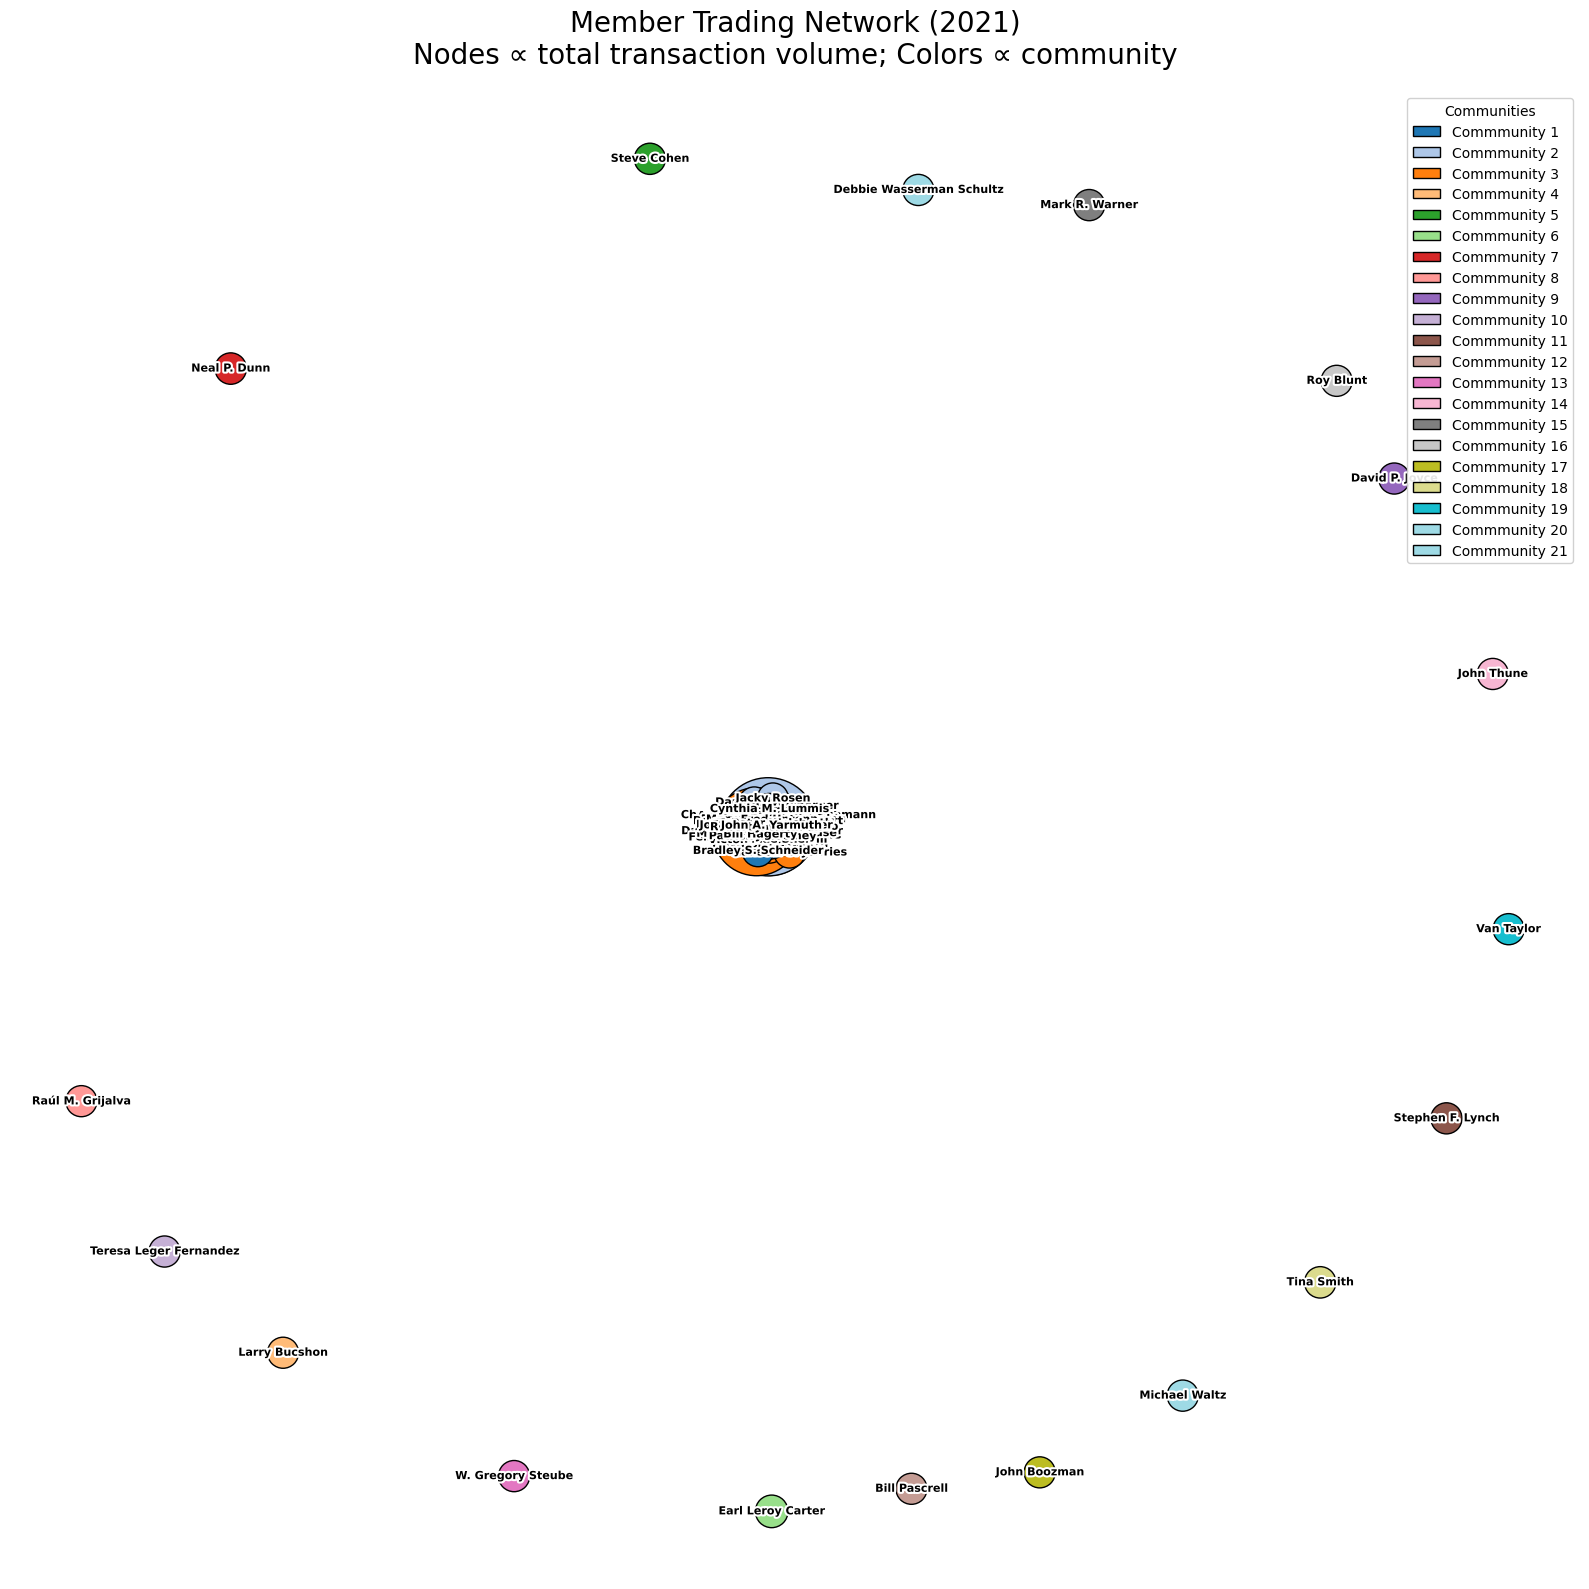

In [39]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import combinations
from networkx.algorithms import community, bipartite
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as patheffects
from networkx.algorithms.bipartite import weighted_projected_graph

# --- CONFIG ---
DATA_DIR = '../data/cleaned/2021-2023'
YEAR     = 2021
CSV_PATH = f'{DATA_DIR}/stocks.csv'

# --- 1) LOAD & FILTER ---
stock_tx = pd.read_csv(CSV_PATH, parse_dates=['transaction_date'])
stock_tx = stock_tx[stock_tx['year'] == YEAR]


# --- 3) TOTAL VOLUME PER MEMBER ---
member_vol = (
    stock_tx
    .groupby(['member_id','member'], as_index=False)['amount']
    .sum()
    .rename(columns={'amount':'total_volume'})
)

# --- 4) AGGREGATE MEMBER–TICKER ---
mt = (
    stock_tx
    .groupby(['member_id','member','ticker'], as_index=False)
    .agg(
        total_amount=('amount','sum'),
        trades_count =('amount','count')
    )
)

# --- 5) BUILD BIPARTITE GRAPH B ---
B = nx.Graph()
# add member nodes
for _, row in member_vol.iterrows():
    B.add_node(row['member_id'],
               bipartite='members',
               name=row['member'],
               total_volume=row['total_volume'])
# add ticker nodes
tickers = mt['ticker'].unique().tolist()
B.add_nodes_from(tickers, bipartite='tickers')
# add edges: weight = total_amount on that ticker
for _, row in mt.iterrows():
    B.add_edge(
        row['member_id'],
        row['ticker'],
        weight=row['total_amount'],
        trades=row['trades_count']
    )

# pull out the two node sets
members = [n for n,d in B.nodes(data=True) if d['bipartite']=='members']

# --- 6) PROJECT TO MEMBER–MEMBER GRAPH M (amount-weighted) ---
M = nx.Graph()
M.add_nodes_from(members)
for ticker in tickers:
    traders = [n for n in B.neighbors(ticker) if B.nodes[n]['bipartite']=='members']
    for u, v in combinations(traders, 2):
        w = B.edges[u, ticker]['weight'] + B.edges[v, ticker]['weight']
        if M.has_edge(u, v):
            M[u][v]['weight'] += w
        else:
            M.add_edge(u, v, weight=w)
            
print("B nodes  :", B.number_of_nodes())
print("B edges  :", B.number_of_edges())

members = [n for n,d in B.nodes(data=True) if d['bipartite']=='members']
print("⟶ members:", len(members))
print("⟶ tickers:", len(set(n for n,d in B.nodes(data=True) if d['bipartite']=='tickers')))

# 1) pick only those tickers that have been traded by 2+ members
common_tickers = [t for t in tickers if B.degree(t) >= 2]

# 2) induce a smaller bipartite graph
B2 = B.subgraph(members + common_tickers).copy()

# 3) project to members, summing the 'weight' attribute
M = weighted_projected_graph(B2, members)

print("Filtered B2 edges:", B2.number_of_edges())
print("Projected M edges:", M.number_of_edges())

comms     = list(community.greedy_modularity_communities(M, weight='weight'))
node_comm = {n:i for i,comm in enumerate(comms) for n in comm}
num_comms = len(comms)

raw  = np.array([B.nodes[n]['total_volume'] for n in M.nodes()], float)
sizes = 500 + (raw/raw.max())*(5000-500) if raw.max()>0 else np.full_like(raw,500)

# 3) layout
pos = nx.spring_layout(M, k=0.08, iterations=200, seed=42)

# 4) build colors
cmap = plt.cm.get_cmap('tab20', num_comms)
node_colors = [cmap(node_comm[n]) for n in M.nodes()]

# 5) draw
fig, ax = plt.subplots(figsize=(16,16))
ax.set_facecolor('white')


# nodes
nx.draw_networkx_nodes(M, pos,
    node_color=node_colors,
    node_size=sizes,
    edgecolors='k',
    linewidths=1,
    ax=ax
)

id_to_name = {
    n: d['name']
    for n,d in B.nodes(data=True)
    if d.get('bipartite')=='members'
}

# labels with halo
for n in M.nodes():
    x,y = pos[n]
    txt = ax.text(x, y, id_to_name[n],
                  fontsize=8, fontweight='bold',
                  ha='center', va='center')
    txt.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='white'),
        patheffects.Normal()
    ])

# legend
legend_handles = [
    Patch(facecolor=cmap(i), edgecolor='k', label=f"Commmunity {i+1}")
    for i in range(num_comms)
]
ax.legend(handles=legend_handles,
          loc='upper right', title='Communities',
          frameon=True, framealpha=0.9)

ax.set_title(
    "Member Trading Network (2021)\n"
    "Nodes ∝ total transaction volume; Colors ∝ community",
    fontsize=20, pad=20
)
ax.axis('off')
fig.savefig('../results/images/member_trading_network_2021.png', 
            dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

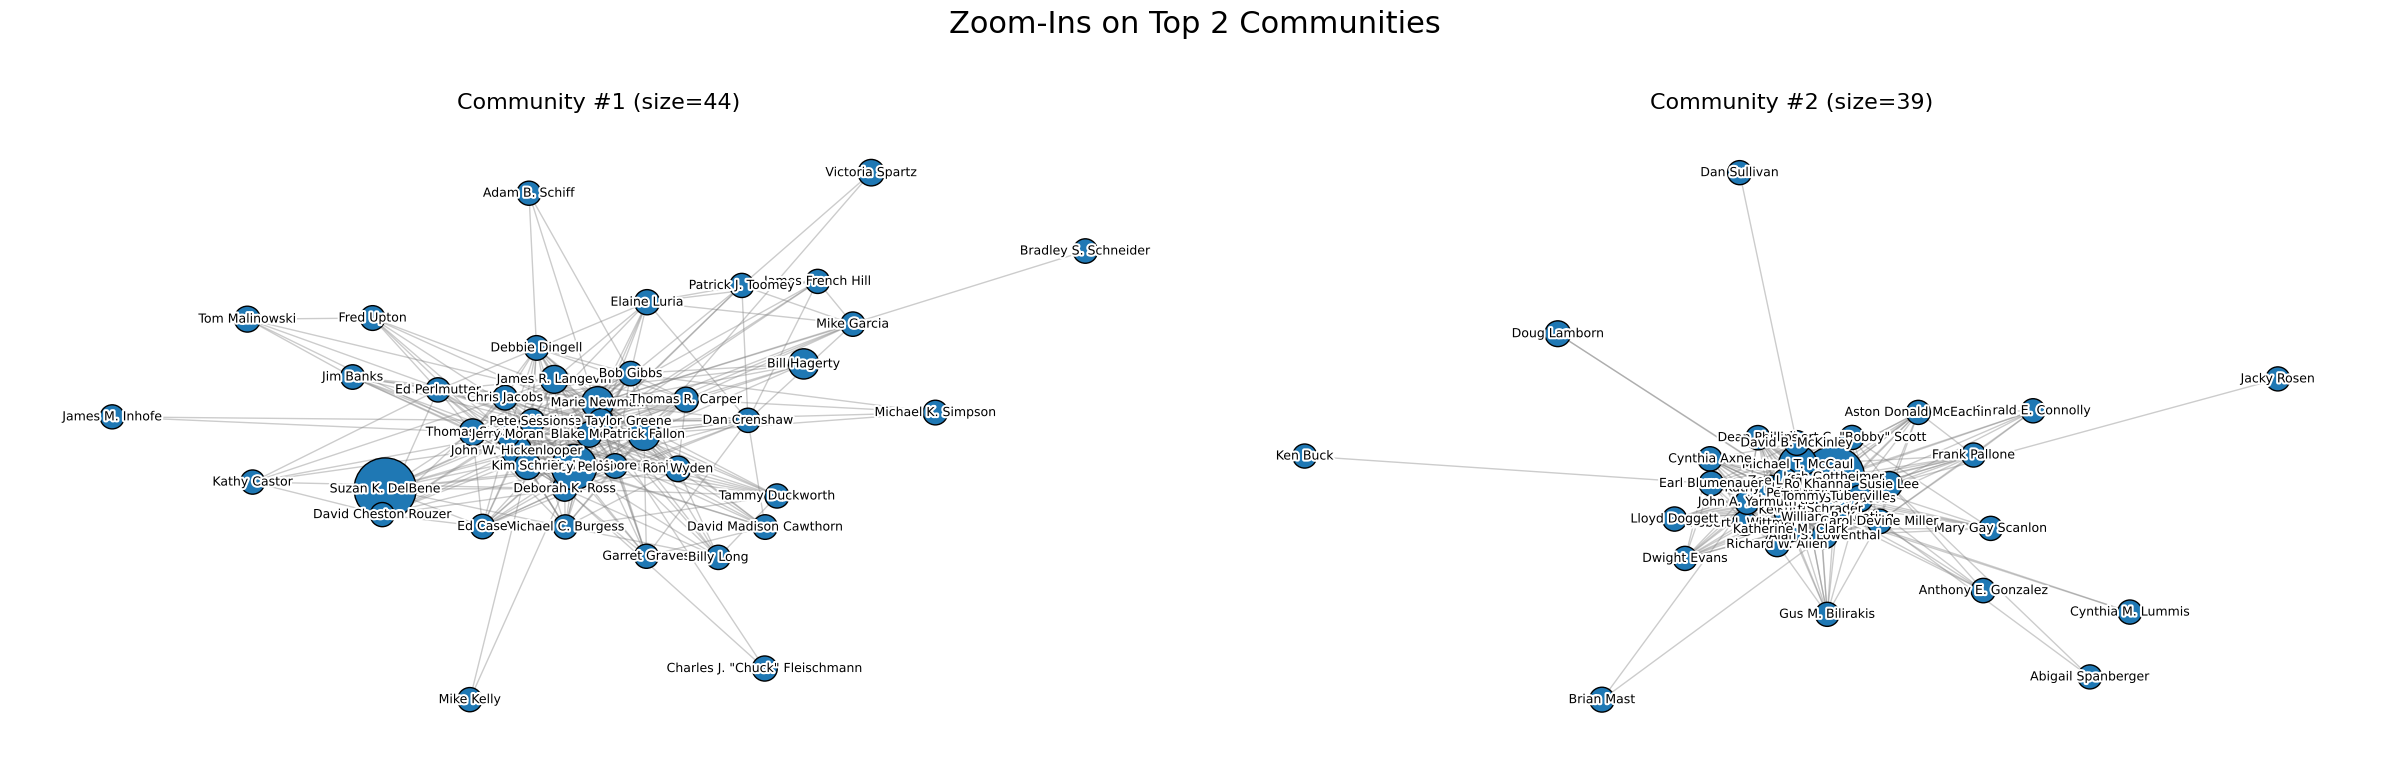

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# --- 1) Identify the top-2 communities by size ---
top2 = sorted(comms, key=len, reverse=True)[:2]

# --- 2) Prepare a 1×2 subplot canvas ---
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
fig.suptitle("Zoom-Ins on Top 2 Communities", fontsize=22, y=0.95)

for ax, comm in zip(axes, top2):
    # induced subgraph
    SG = M.subgraph(comm).copy()

    # layout: larger k to spread nodes
    pos = nx.spring_layout(SG, k=0.3, iterations=200, seed=42)

    # draw edges
    nx.draw_networkx_edges(SG, pos, ax=ax, alpha=0.4, edge_color='gray')

    # node sizes by total_volume
    raw = [B.nodes[n]['total_volume'] for n in SG.nodes()]
    maxv = max(raw)
    sizes = [300 + (v/maxv)*1700 for v in raw]

    # draw nodes
    nx.draw_networkx_nodes(
        SG, pos, 
        node_size=sizes, 
        node_color='#1f78b4', 
        edgecolors='k', 
        linewidths=1, 
        ax=ax
    )

    # draw labels with white halo
    for n in SG.nodes():
        x, y = pos[n]
        txt = ax.text(x, y, id_to_name[n],
                      fontsize=9, ha='center', va='center')
        txt.set_path_effects([
            patheffects.Stroke(linewidth=3, foreground='white'),
            patheffects.Normal()
        ])

    ax.set_title(f"Community #{top2.index(comm)+1} (size={len(comm)})", fontsize=16)
    ax.axis('off')

plt.tight_layout(rect=[0,0,1,0.92])
fig.savefig('../results/images/top_2_communities_2021.png', 
            dpi=300, bbox_inches='tight')
plt.show()


In [38]:
# — derive member’s chamber (assumes stock_tx has chamber per transaction) —
member_chamber = (
    stock_tx[['member_id','chamber']]
    .drop_duplicates(subset='member_id')
)

# — combine with total_volume and member name —
member_info = (
    member_vol
    .merge(member_chamber, on='member_id')
    .rename(columns={'member':'name'})
)

# — pick your top–2 communities by size —
top3_comms = sorted(comms, key=len, reverse=True)[:2]

for idx, comm in enumerate(top3_comms, start=1):
    print(f"\n=== Community #{idx} (size {len(comm)}) ===")
    
    # filter to only members in this community
    comm_df = member_info[member_info['member_id'].isin(comm)]
    
    # top-3 by total_volume in each chamber
    top5_house  = comm_df[comm_df['chamber']=='House'] .nlargest(3, 'total_volume')
    top5_senate = comm_df[comm_df['chamber']=='Senate'].nlargest(3, 'total_volume')
    
    print("Top 3 House members by volume:")
    print(top5_house[['member_id','name','total_volume']].to_string(index=False))
    
    print("\nTop 3 Senate members by volume:")
    print(top5_senate[['member_id','name','total_volume']].to_string(index=False))



=== Community #1 (size 44) ===
Top 3 House members by volume:
member_id             name  total_volume
  D000617 Suzan K. DelBene      46316000
  P000197     Nancy Pelosi      20775000
  N000192     Marie Newman       6480000

Top 3 Senate members by volume:
member_id                 name  total_volume
     S407         Bill Hagerty       4723000
     S408 John W. Hickenlooper       4688000
     S247            Ron Wyden       1064000

=== Community #2 (size 39) ===
Top 3 House members by volume:
member_id              name  total_volume
  G000583   Josh Gottheimer      66965000
  M001157 Michael T. McCaul      18646000
  H001082        Kevin Hern      16472000

Top 3 Senate members by volume:
member_id              name  total_volume
     S412  Tommy Tuberville       5878000
     S410 Cynthia M. Lummis         83000
     S383      Dan Sullivan         35000
